# IA048A - EFC 03: Redes Neurais Artificiais

### Luís Antônio Almeida Lima Vieira (221045)  &  Nathan Shen Baldon (242448)

In [1]:
!pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 3.2 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115942 sha256=3d945bef574b5f08483aeacc77c9085755e9c3d6cefa3dca64c163d79433a549
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire


In [2]:
# É necessário antes de tudo instalar a biblioteca medmnist

# Importações necessárias
import sklearn
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import os 
from tqdm import tqdm
import medmnist
from medmnist import INFO, Evaluator
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras

# to make this notebook's output stable across runs
#np.random.seed(42) # indica onde escolha aleatória começa
SEED = 1984
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
tf.config.experimental.enable_op_determinism()

# to make pretty figures
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
EFC = "efc3"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", EFC)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="svg"):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension)

In [3]:
# Verificando se a GPU foi conectada
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Importação da base de dados BloodMNIST


In [4]:
# Importando o dataset bloodmnist
data_flag = 'bloodmnist'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [5]:
# carregando os dados
train_dataset = DataClass(split='train', download=download)
val_dataset = DataClass(split='val', download=download)
test_dataset = DataClass(split='test', download=download)

  0%|          | 0/35461855 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz


In [6]:
info

{'python_class': 'BloodMNIST',
 'description': 'The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.',
 'url': 'https://zenodo.org/record/6496656/files/bloodmnist.npz?download=1',
 'MD5': '7053d0359d879ad8a5505303e11de1dc',
 'task': 'multi-class',
 'label': {'0': 'basophil',
  '1': 'eosinophil',
  '2': 'erythroblast',
  '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)',
  '4': 'lymphocyte',
  '5': 'monocyte',
  '6': 'neutrophil',
  '7': 'platelet'},
 'n_channels': 3,
 'n_samples': {'train': 11959, 'val': 1712, 'test': 3421},
 '

In [7]:
# Separando os labels por conjunto:
train_labels = train_dataset.labels
val_labels = val_dataset.labels
test_labels = test_dataset.labels

In [8]:
# Separando as imagens por conjunto:
train_img = train_dataset.imgs
val_img = val_dataset.imgs
test_img = test_dataset.imgs

In [9]:
print(np.shape(train_img[0]))

(28, 28, 3)


Rótulo: [7] (Plaquetas)
Saving figure imagem_um


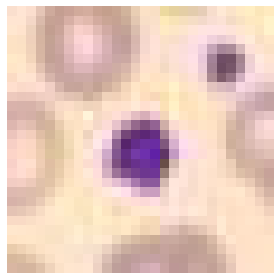

In [10]:
# Vizualização da primeira imagem do conjunto de treinamento
print(f"Rótulo: {train_labels[0]} (Plaquetas)")
plt.imshow(train_img[0],cmap="gray")
plt.axis("off")
save_fig('imagem_um')
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


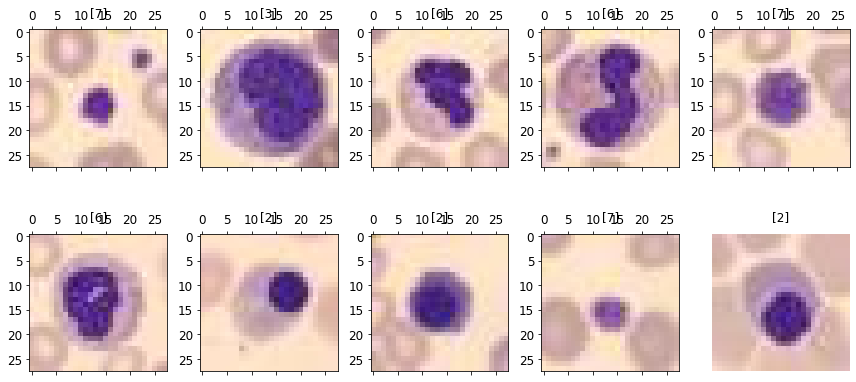

In [11]:
# Vizualização das 10 primeiras imagens do conjunto de treinamento com seus respectivos labels
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(train_img[n])
        axs[i,j].set(title=train_labels[n])
        plt.axis("off")
        n=n+1
plt.show()

### Classes do conjunto


 Id | Rótulo                       |
--- |:--------------------------------:|
0  | Basófilos   |
1  | Eosinófilos |
2  | Eritroblastos   |
3  | Granulócitos imaturos   |
4  | Linfócitos   |
5  | Monócitos   |
6  | Neutrófilos   |
7  | Plaquetas   |


## Avaliação do conjunto de dados


In [12]:
# Balanceamento do conjunto de treinamento
num_basofilos_t = (train_labels==0).sum()
num_eosinofilos_t = (train_labels==1).sum()
num_eritroblastos_t = (train_labels==2).sum()
num_granulocitos_t = (train_labels==3).sum()
num_linfocitos_t = (train_labels==4).sum()
num_monocitos_t = (train_labels==5).sum()
num_neutrofilos_t = (train_labels==6).sum()
num_plaquetas_t = (train_labels==7).sum()
p_basofilos_t = num_basofilos_t*100/len(train_labels)
p_eosinofilos_t = num_eosinofilos_t*100/len(train_labels)
p_eritroblastos_t = num_eritroblastos_t*100/len(train_labels)
p_granulocitos_t = num_granulocitos_t*100/len(train_labels)
p_linfocitos_t = num_linfocitos_t*100/len(train_labels)
p_monocitos_t = num_monocitos_t*100/len(train_labels)
p_neutrofilos_t = num_neutrofilos_t*100/len(train_labels)
p_plaquetas_t = num_plaquetas_t*100/len(train_labels)
print("No conjunto de treinamento há",num_basofilos_t, "Basófilos")
print("Porcentagem de classes 0:",p_basofilos_t ,"%")
print("No conjunto de treinamento há",num_eosinofilos_t, "Eosinófilos")
print("Porcentagem de classes 1:",p_eosinofilos_t,"%")
print("No conjunto de treinamento há",num_eritroblastos_t, "Eritroblastos")
print("Porcentagem de classes 2:",p_eritroblastos_t,"%")
print("No conjunto de treinamento há",num_granulocitos_t, "Granulócitos imaturos")
print("Porcentagem de classes 3:",p_granulocitos_t,"%")
print("No conjunto de treinamento há",num_linfocitos_t, "Linfócitos")
print("Porcentagem de classes 4:",p_linfocitos_t,"%")
print("No conjunto de treinamento há",num_monocitos_t, "Monócitos")
print("Porcentagem de classes 5:",p_monocitos_t,"%")
print("No conjunto de treinamento há",num_neutrofilos_t, "Neutrófilos")
print("Porcentagem de classes 6:",p_neutrofilos_t,"%")
print("No conjunto de treinamento há",num_plaquetas_t, "Plaquetas")
print("Porcentagem de classes 7:",p_plaquetas_t,"%")

No conjunto de treinamento há 852 Basófilos
Porcentagem de classes 0: 7.124341500125428 %
No conjunto de treinamento há 2181 Eosinófilos
Porcentagem de classes 1: 18.237310811940798 %
No conjunto de treinamento há 1085 Eritroblastos
Porcentagem de classes 2: 9.072664938540012 %
No conjunto de treinamento há 2026 Granulócitos imaturos
Porcentagem de classes 3: 16.941215820720796 %
No conjunto de treinamento há 849 Linfócitos
Porcentagem de classes 4: 7.099255790617945 %
No conjunto de treinamento há 993 Monócitos
Porcentagem de classes 5: 8.303369846977173 %
No conjunto de treinamento há 2330 Neutrófilos
Porcentagem de classes 6: 19.48323438414583 %
No conjunto de treinamento há 1643 Plaquetas
Porcentagem de classes 7: 13.738606906932018 %


In [13]:
# Balanceamento do conjunto de validação
num_basofilos_v = (val_labels==0).sum()
num_eosinofilos_v = (val_labels==1).sum()
num_eritroblastos_v = (val_labels==2).sum()
num_granulocitos_v = (val_labels==3).sum()
num_linfocitos_v = (val_labels==4).sum()
num_monocitos_v = (val_labels==5).sum()
num_neutrofilos_v = (val_labels==6).sum()
num_plaquetas_v = (val_labels==7).sum()
p_basofilos_v = num_basofilos_v*100/len(val_labels)
p_eosinofilos_v = num_eosinofilos_v*100/len(val_labels)
p_eritroblastos_v = num_eritroblastos_v*100/len(val_labels)
p_granulocitos_v = num_granulocitos_v*100/len(val_labels)
p_linfocitos_v = num_linfocitos_v*100/len(val_labels)
p_monocitos_v = num_monocitos_v*100/len(val_labels)
p_neutrofilos_v = num_neutrofilos_v*100/len(val_labels)
p_plaquetas_v = num_plaquetas_v*100/len(val_labels)
print("No conjunto de validação há",num_basofilos_v, "Basófilos")
print("Porcentagem de classes 0:",p_basofilos_v ,"%")
print("No conjunto de validação há",num_eosinofilos_v, "Eosinófilos")
print("Porcentagem de classes 1:",p_eosinofilos_v,"%")
print("No conjunto de validação há",num_eritroblastos_v, "Eritroblastos")
print("Porcentagem de classes 2:",p_eritroblastos_v,"%")
print("No conjunto de validação há",num_granulocitos_v, "Granulócitos imaturos")
print("Porcentagem de classes 3:",p_granulocitos_v,"%")
print("No conjunto de validação há",num_linfocitos_v, "Linfócitos")
print("Porcentagem de classes 4:",p_linfocitos_v,"%")
print("No conjunto de validação há",num_monocitos_v, "Monócitos")
print("Porcentagem de classes 5:",p_monocitos_v,"%")
print("No conjunto de validação há",num_neutrofilos_v, "Neutrófilos")
print("Porcentagem de classes 6:",p_neutrofilos_v,"%")
print("No conjunto de validação há",num_plaquetas_v, "Plaquetas")
print("Porcentagem de classes 7:",p_plaquetas_v,"%")

No conjunto de validação há 122 Basófilos
Porcentagem de classes 0: 7.126168224299065 %
No conjunto de validação há 312 Eosinófilos
Porcentagem de classes 1: 18.22429906542056 %
No conjunto de validação há 155 Eritroblastos
Porcentagem de classes 2: 9.05373831775701 %
No conjunto de validação há 290 Granulócitos imaturos
Porcentagem de classes 3: 16.939252336448597 %
No conjunto de validação há 122 Linfócitos
Porcentagem de classes 4: 7.126168224299065 %
No conjunto de validação há 143 Monócitos
Porcentagem de classes 5: 8.352803738317757 %
No conjunto de validação há 333 Neutrófilos
Porcentagem de classes 6: 19.450934579439252 %
No conjunto de validação há 235 Plaquetas
Porcentagem de classes 7: 13.726635514018692 %


In [14]:
# Balanceamento do conjunto de teste
num_basofilos_tt = (test_labels==0).sum()
num_eosinofilos_tt = (test_labels==1).sum()
num_eritroblastos_tt = (test_labels==2).sum()
num_granulocitos_tt = (test_labels==3).sum()
num_linfocitos_tt = (test_labels==4).sum()
num_monocitos_tt = (test_labels==5).sum()
num_neutrofilos_tt = (test_labels==6).sum()
num_plaquetas_tt = (test_labels==7).sum()
p_basofilos_tt = num_basofilos_tt*100/len(test_labels)
p_eosinofilos_tt = num_eosinofilos_tt*100/len(test_labels)
p_eritroblastos_tt = num_eritroblastos_tt*100/len(test_labels)
p_granulocitos_tt = num_granulocitos_tt*100/len(test_labels)
p_linfocitos_tt = num_linfocitos_tt*100/len(test_labels)
p_monocitos_tt = num_monocitos_tt*100/len(test_labels)
p_neutrofilos_tt = num_neutrofilos_tt*100/len(test_labels)
p_plaquetas_tt = num_plaquetas_tt*100/len(test_labels)
print("No conjunto de teste há",num_basofilos_tt, "Basófilos")
print("Porcentagem de classes 0:",p_basofilos_tt ,"%")
print("No conjunto de teste há",num_eosinofilos_tt, "Eosinófilos")
print("Porcentagem de classes 1:",p_eosinofilos_tt,"%")
print("No conjunto de teste há",num_eritroblastos_tt, "Eritroblastos")
print("Porcentagem de classes 2:",p_eritroblastos_tt,"%")
print("No conjunto de teste há",num_granulocitos_tt, "Granulócitos imaturos")
print("Porcentagem de classes 3:",p_granulocitos_tt,"%")
print("No conjunto de teste há",num_linfocitos_tt, "Linfócitos")
print("Porcentagem de classes 4:",p_linfocitos_tt,"%")
print("No conjunto de teste há",num_monocitos_tt, "Monócitos")
print("Porcentagem de classes 5:",p_monocitos_tt,"%")
print("No conjunto de teste há",num_neutrofilos_tt, "Neutrófilos")
print("Porcentagem de classes 6:",p_neutrofilos_tt,"%")
print("No conjunto de teste há",num_plaquetas_tt, "Plaquetas")
print("Porcentagem de classes 7:",p_plaquetas_tt,"%")

No conjunto de teste há 244 Basófilos
Porcentagem de classes 0: 7.1324174218064895 %
No conjunto de teste há 624 Eosinófilos
Porcentagem de classes 1: 18.240280619701842 %
No conjunto de teste há 311 Eritroblastos
Porcentagem de classes 2: 9.090909090909092 %
No conjunto de teste há 579 Granulócitos imaturos
Porcentagem de classes 3: 16.9248757673195 %
No conjunto de teste há 243 Linfócitos
Porcentagem de classes 4: 7.103186202864659 %
No conjunto de teste há 284 Monócitos
Porcentagem de classes 5: 8.301666179479684 %
No conjunto de teste há 666 Neutrófilos
Porcentagem de classes 6: 19.467991815258696 %
No conjunto de teste há 470 Plaquetas
Porcentagem de classes 7: 13.73867290266004 %


## Preparação do conjunto de dados


In [15]:
# Dividindo os valores das imagens por 255, para manter a intensidade dos pixels com valores entre 0 e 1
x_train = train_img/255
x_valid = val_img/255
x_test = test_img/255
y_train = np.ravel(train_labels)
y_valid = np.ravel(val_labels)
y_test = np.ravel(test_labels)
# Criando o conjunto validação+treino para uso posterior
x_tv=np.concatenate((x_train,x_valid))
y_tv=np.concatenate((y_train,y_valid))
print("Formato do x_train: ", x_train.shape)
print("Formato do x_valid: ", x_valid.shape)
print("Formato do x_test: ", x_test.shape)
print("Formato do y_train: ", y_train.shape)
print("Formato do y_valid: ", y_valid.shape)
print("Formato do y_test: ", y_test.shape)
print("Valor máximo no treinamento: ", np.max(x_train))
print("Valor máximo no treinamento: ",np.min(x_train))

Formato do x_train:  (11959, 28, 28, 3)
Formato do x_valid:  (1712, 28, 28, 3)
Formato do x_test:  (3421, 28, 28, 3)
Formato do y_train:  (11959,)
Formato do y_valid:  (1712,)
Formato do y_test:  (3421,)
Valor máximo no treinamento:  1.0
Valor máximo no treinamento:  0.0


## Treinamento MLP de **uma** camada intermediária



In [ ]:
def build_model(n_hidden, n_neurons, learning_rate, input_shape=[28,28,3]):
  model = keras.models.Sequential()
  model.add(keras.layers.InputLayer(input_shape=input_shape))
  for layer in range(n_hidden):
    model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)
  return model

Ajustes realizados:
* número de neurônios (100, 300 e 1500)
* class_weight (balanced, None)
* optimizer, learning rate (.01)
* função de ativação (relu, selu e sigmoid)
* métrica otimizada (accuracy)
* função custo 
* kernels inicializados aleatoriamentes (padrão da função Dense() do Keras)
* número de épocas (50, 100 e 200)





In [ ]:
# definindo a MLP
model_MLP1 = keras.models.Sequential()
model_MLP1.add(keras.layers.Flatten(input_shape=[28, 28, 3])) 
model_MLP1.add(keras.layers.Dense(300, activation="relu")) # camada intermediária 
model_MLP1.add(keras.layers.Dense(8, activation="softmax")) # camada de saída

model_MLP1.summary() # resume o formato da MLP

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2352)              0         
                                                                 
 dense (Dense)               (None, 300)               705900    
                                                                 
 dense_1 (Dense)             (None, 8)                 2408      
                                                                 
Total params: 708,308
Trainable params: 708,308
Non-trainable params: 0
_________________________________________________________________


Sobre o modelo:
* loss: SparseCategoricalCrossentropy, pois é a recomendada para o cenário com mais de 2 classe em que as classes são representadas por números inteiros (ref: https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class)
* função de ativação RELu foi a escolha inicial por sua popularidade e foi a que apresentou melhor acurácia nos testes iniciais
* camada Flatten preprocessa os dados de entrada, deixando-os em formato de uma dimensão
* camada Dense: 
* camada de saída: composta por 8 neurônios, cada um representando uma possível classe. A função de ativação escolhida foi a softmax, devido ao cenário ser de multi-classe em que deseja-se inferir apenas a classe que a amostra pertence. 

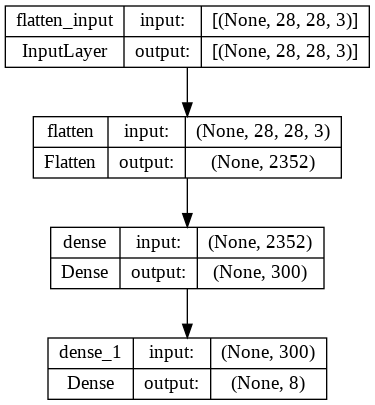

In [ ]:
keras.utils.plot_model(model_MLP1, "MLP_1L_model.png", show_shapes=True)

In [ ]:
# compila o modelo de MLP criado
model_MLP1.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=["accuracy"])

# calcula os pesos de cada classe para balanceamento no treinamento
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes = np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
history = model_MLP1.fit(x_train, y_train, epochs=200,
                    validation_data=(x_valid, y_valid), class_weight=class_weights)

Epoch 1/200
374/374 [==============================] - 2s 5ms/step - loss: 1.5561 - accuracy: 0.4008 - val_loss: 1.3420 - val_accuracy: 0.4737
Epoch 2/200
374/374 [==============================] - 2s 5ms/step - loss: 1.2022 - accuracy: 0.5539 - val_loss: 1.2367 - val_accuracy: 0.5362
Epoch 3/200
374/374 [==============================] - 2s 4ms/step - loss: 1.0795 - accuracy: 0.6168 - val_loss: 0.9920 - val_accuracy: 0.6758
Epoch 4/200
374/374 [==============================] - 2s 4ms/step - loss: 1.0128 - accuracy: 0.6456 - val_loss: 1.0324 - val_accuracy: 0.6121
Epoch 5/200
374/374 [==============================] - 1s 4ms/step - loss: 0.9643 - accuracy: 0.6610 - val_loss: 0.8751 - val_accuracy: 0.7097
Epoch 6/200
374/374 [==============================] - 1s 4ms/step - loss: 0.9253 - accuracy: 0.6817 - val_loss: 0.9613 - val_accuracy: 0.6396
Epoch 7/200
374/374 [==============================] - 2s 4ms/step - loss: 0.9003 - accuracy: 0.6865 - val_loss: 0.8109 - val_accuracy: 0.7395

In [ ]:
#model_MLP1.save("MLP1.h5")
#model_MLP1 = keras.models.load_model("MLP1.h5")
checkpoint_cb = keras.callbacks.ModelCheckpoint("MLP1.h5", save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
restore_best_weights=True)
history = model_MLP1.fit(x_train, y_train, epochs=200, validation_data=(x_valid, y_valid), callbacks=[checkpoint_cb, early_stopping_cb], class_weight=class_weights)

mse_test = model_MLP1.evaluate(x_test, y_test)

Epoch 1/200
374/374 [==============================] - 2s 4ms/step - loss: 0.7429 - accuracy: 0.7491 - val_loss: 0.6501 - val_accuracy: 0.7652
Epoch 2/200
374/374 [==============================] - 1s 4ms/step - loss: 0.6530 - accuracy: 0.7736 - val_loss: 0.7701 - val_accuracy: 0.7103
Epoch 3/200
374/374 [==============================] - 1s 4ms/step - loss: 0.6250 - accuracy: 0.7802 - val_loss: 0.5540 - val_accuracy: 0.7961
Epoch 4/200
374/374 [==============================] - 1s 4ms/step - loss: 0.6019 - accuracy: 0.7901 - val_loss: 0.7851 - val_accuracy: 0.7301
Epoch 5/200
374/374 [==============================] - 1s 4ms/step - loss: 0.5733 - accuracy: 0.8010 - val_loss: 0.4727 - val_accuracy: 0.8341
Epoch 6/200
374/374 [==============================] - 1s 4ms/step - loss: 0.5702 - accuracy: 0.8030 - val_loss: 0.5492 - val_accuracy: 0.7909
Epoch 7/200
374/374 [==============================] - 2s 4ms/step - loss: 0.5623 - accuracy: 0.8053 - val_loss: 0.4583 - val_accuracy: 0.8376

Saving figure keras_learning_curves_plot


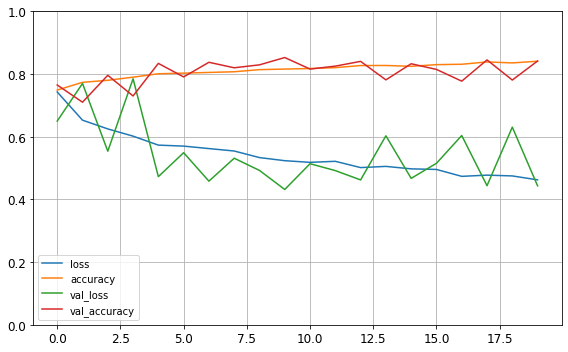

107/107 [==============================] - 0s 3ms/step - loss: 0.4771 - accuracy: 0.8337


[0.47710075974464417, 0.8336743712425232]

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

model_MLP1.evaluate(x_test, y_test)

In [ ]:
# exibe a probabilidade estimada de cada classe para as três primeiras amostras do conjunto de teste
x_new = x_test[:3]
y_proba_MLP1 = model_MLP1.predict(x_new)
print(y_proba_MLP1.round(2))

y_pred_MLP1 = np.argmax(model_MLP1.predict(x_test), axis=-1) # indica classe com maior probabilidade
print(y_pred_MLP1[:3])
print(y_test[:3])

1/1 [==============================] - 0s 70ms/step
[[0.03 0.   0.   0.29 0.01 0.67 0.   0.  ]
 [0.68 0.25 0.   0.04 0.   0.04 0.   0.  ]
 [0.   0.98 0.   0.   0.   0.   0.01 0.  ]]
107/107 [==============================] - 0s 2ms/step
[5 0 1]
[3 0 1]


### Acurácia


In [ ]:
# Resumo do modelo
print("Model summary")
model_MLP1.summary() # print model summary
print("")

# Model Evaluation
print("Model Evaluation")
MLP1_test = model_MLP1.evaluate(x_test, y_test)
print("A acurácia global para os dados de teste obtida foi de 0.8427")

Model summary
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2352)              0         
                                                                 
 dense (Dense)               (None, 300)               705900    
                                                                 
 dense_1 (Dense)             (None, 8)                 2408      
                                                                 
Total params: 708,308
Trainable params: 708,308
Non-trainable params: 0
_________________________________________________________________

Model Evaluation
107/107 [==============================] - 0s 2ms/step - loss: 0.4771 - accuracy: 0.8337
A acurácia global para os dados de teste obtida foi de 0.8427


### Matriz de confusão

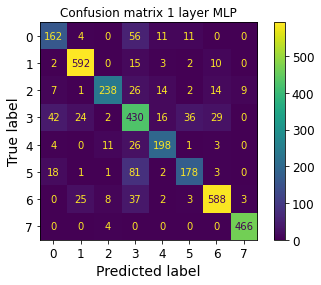

In [ ]:
# Matriz de confusão
MLP1_cm=metrics.confusion_matrix(y_test, y_pred_MLP1)
cm_fig=metrics.ConfusionMatrixDisplay(confusion_matrix=MLP1_cm)
cm_fig.plot()
plt.title('Confusion matrix 1 layer MLP')
plt.show()

## Treinamento MLP de **duas** camadas intermediárias

In [ ]:
# definindo a MLP
model_MLP1 = keras.models.Sequential()
model_MLP1.add(keras.layers.Flatten(input_shape=[28, 28, 3])) 
model_MLP1.add(keras.layers.Dense(100, activation="relu")) # camada intermediária 
model_MLP1.add(keras.layers.Dense(300, activation="relu")) # camada intermediária 
model_MLP1.add(keras.layers.Dense(8, activation="softmax")) # camada de saída

model_MLP1.summary() # resume o formato da MLP

In [ ]:
keras.utils.plot_model(model_MLP1, "MLP_2L_model.png", show_shapes=True)

In [ ]:
# exibe a probabilidade estimada de cada classe para as três primeiras amostras do conjunto de teste
x_new = x_test[:3]
y_proba_MLP2 = model_MLP2.predict(x_new)
print(y_proba_MLP2.round(2))

y_pred_MLP2 = np.argmax(model_MLP2.predict(x_test), axis=-1) # indica classe com maior probabilidade
print(y_pred_MLP2[:3])
print(y_test[:3])

In [ ]:
# Resumo do modelo
print("Model summary")
model_MLP2.summary() # print model summary
print("")

# Model Evaluation
print("Model Evaluation")
MLP2_test = model_MLP2.evaluate(x_test, y_test)
print("A acurácia global para os dados de teste obtida foi de 0.8427")

In [ ]:
# Matriz de confusão
MLP2_cm=metrics.confusion_matrix(y_test, y_pred_MLP2)
cm_fig=metrics.ConfusionMatrixDisplay(confusion_matrix=MLP2_cm)
cm_fig.plot()
plt.title('Confusion matrix 2 layer MLP')
plt.show()

## Treinamento e validação da CNN Simples

- Variando o número de Kernels:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Para o n_kernels = 1


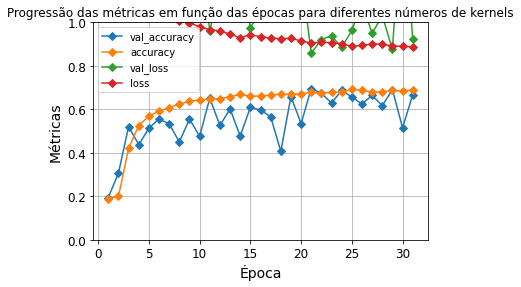

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Para o n_kernels = 5


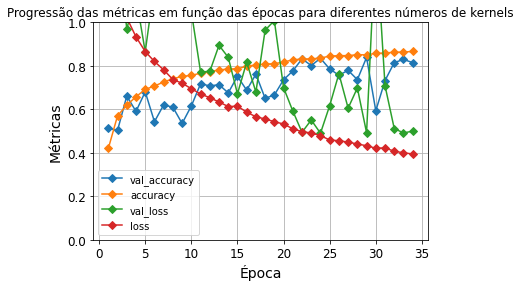

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Para o n_kernels = 10


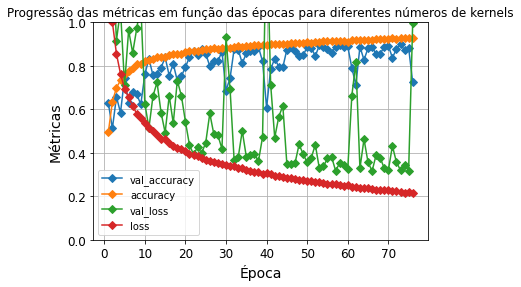

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Para o n_kernels = 15


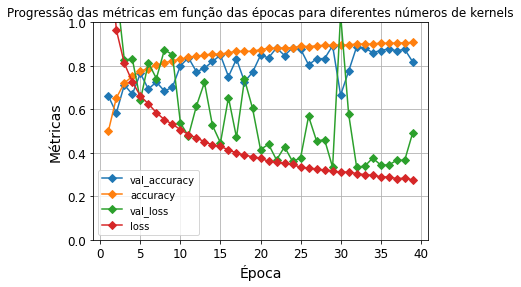

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Para o n_kernels = 20


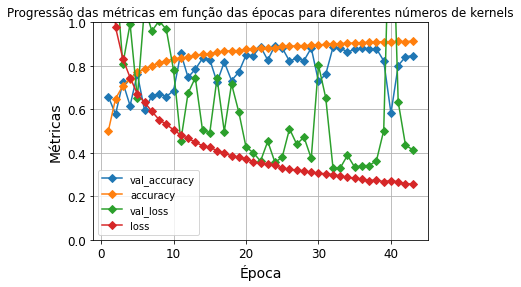

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Para o n_kernels = 30


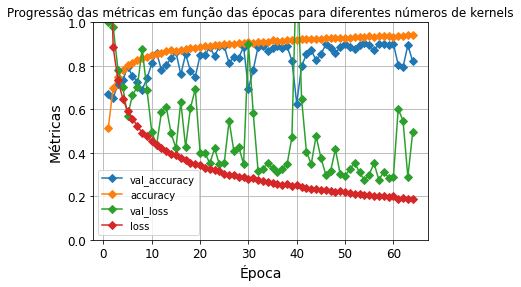

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Para o n_kernels = 40


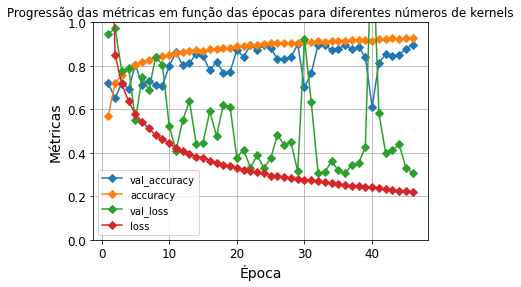

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Para o n_kernels = 50


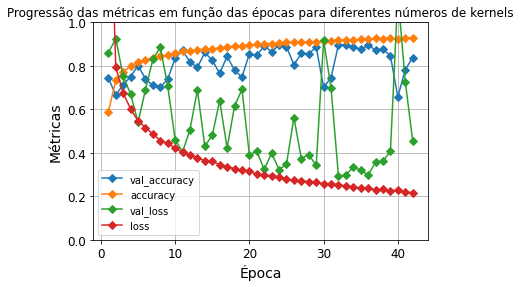

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Para o n_kernels = 100


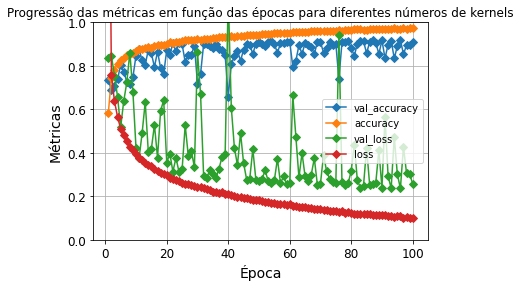

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Para o n_kernels = 150


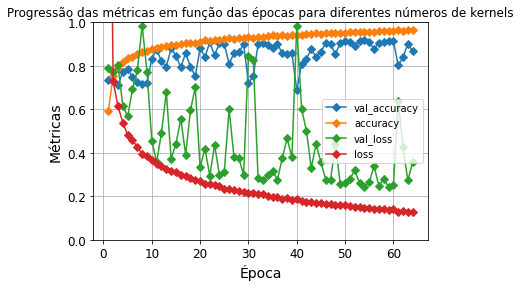

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Para o n_kernels = 200


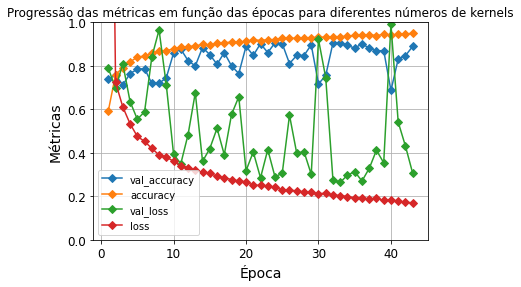

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Para o n_kernels = 250


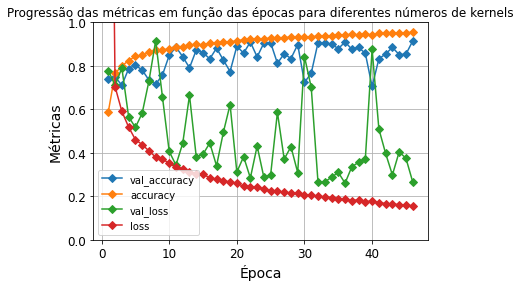

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Para o n_kernels = 350


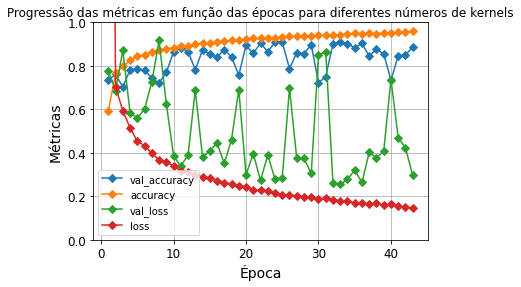

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Para o n_kernels = 500


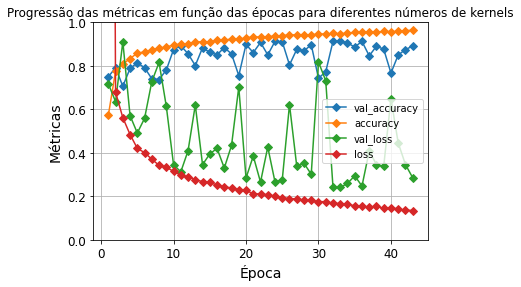

In [16]:
# Primeiro será feito o treinamento fixando todos os parâmetros e variando o número de kernels
# Valores de número de kernels a serem testados:
n_kernels = [1,5,10,15,20,30,40,50,100,150,200,250,350,500]
# Vetor das melhores acurácias de validação
best_val_acc = []
best_val_loss = []
# Vetor das respectivas épocas das melhores acurácias
best_epoch_acc= []
best_epoch_loss= []
for i in np.arange(0,len(n_kernels),1):
  # Construção da CNN
  # definindo o modelo:
  sCNN_model = keras.models.Sequential()
  # Definição da camada convolucional:
  sCNN_model.add(keras.layers.Conv2D(
                  # Será testado pelo KerasTuner diferentes quantidades de kernels
                  filters= int(n_kernels[i]), # Número de Kernels 
                  kernel_size=(3,3), # Tamanho dos kernels fixado em 3x3
                  strides=(1,1), # Stride unitário ao logo das duas dimensões da imagem (imagem com poucos pixels)
                  input_shape=[28, 28, 3], # Formato das imagens de entrada [linhas, colunas, canais]
                  padding='same', # Default='valid',"same" faz o zero padding e quando o stride é unitário mantém as dimensões da imagem
                  data_format=None, # Default=None, canais por último no formato de entrada
                  dilation_rate=(1, 1), # Default=(1, 1), sem dilatação da convolução
                  groups=1, # Default=1, apenas um grupo para as entradas
                  activation='relu', # Função de ativação ReLu
                  use_bias=True, # Default=True. Utilizando bias no modelo
                  kernel_initializer='he_uniform', # Default='glorot_uniform'. Modo de inicialização do pesos definido como he_uniform
                  bias_initializer='zeros', # Default='zeros'. Inicia o bias como zero
                  kernel_regularizer=None, # Default=None. Não utiliza regularização
                  bias_regularizer=None, # Default=None. Não utiliza regularização do bias 
                  activity_regularizer=None, # Default=None. Sem função de regularização na saída
                  kernel_constraint=None, # Default=None. Sem Constraint function (definições para os valores dos pesos) no Kernel
                  bias_constraint=None, # Default=Non. Sem Constraint function (definições para os valores dos pesos) no vetor de bias
                  name='2D-Convolutional-Layer') # nome da camada
                ) 
  # Definição da camada de pooling (Foi escolhido o Max Pooling)
  sCNN_model.add(keras.layers.MaxPool2D(pool_size=(2,2), # Default=(2,2). Tamanho da janela de pooling definida como 2x2
                      strides=(1,1), # Definição do stride das janelas de pooling como unitário
                      padding='valid', # Default='valid'. Sem padding
                      data_format=None, # Default=None. Canais por último no formato de entrada
                      name='2D-MaxPool-Layer') # nome da camada
                ) 
  # Definição da camada flatten antes da camada densa
  sCNN_model.add(keras.layers.Flatten(name='Flatten-Layer'))
  # Definição da camada densa de saída do tipo softmax
  sCNN_model.add(keras.layers.Dense(8, activation='softmax', name='Output-Layer'))

  # Compilação do modelo
  sCNN_model.compile(optimizer='sgd', # Otimizador sgd escolhido para o treinamento
                    loss='SparseCategoricalCrossentropy', # Função custo. Escolhida a entropia cruzada
                    metrics=['accuracy'], # A acurácia foi utilizada como métrica
                    )

  # fit do modelo
  sCNN_history = sCNN_model.fit(x_train, # dados de entrada
                    y_train, # labels do treinamento
                    batch_size=50, # Tamanho do batch para o treinamento (quantas amostras usa por vez)
                    epochs=100, # Número de épocas (quantas vezes percorre todos os dados)
                    verbose=0, # Grau de informações printadas
                    callbacks= keras.callbacks.EarlyStopping(monitor='val_loss', patience=10), # Adição de Early Stopping para evitar overfitting
                    validation_data=(x_valid, y_valid) # Dados de validação  
                    )
  print(sCNN_history.history.keys())
  # Salvando os valores das melhores acurácias de validação e as melhores épocas para este parâmetro
  best_val_acc.append(np.max(sCNN_history.history['val_accuracy']))
  best_epoch_acc.append(sCNN_history.history['val_accuracy'].index(np.max(sCNN_history.history['val_accuracy']))+1)
  # Salvando os melhores valores da função custo e as melhores épocas para este parâmetro
  best_val_loss.append(np.min(sCNN_history.history['val_loss']))
  best_epoch_loss.append(sCNN_history.history['val_loss'].index(np.min(sCNN_history.history['val_loss']))+1)
  # Indica quantos kernels estão sendo utilizados
  print("Para o n_kernels =", int(n_kernels[i]))  
  # Plotando os gráficos das métricas em função das épocas
  plt.plot(np.arange(1,len(sCNN_history.history['val_accuracy'])+1,1),sCNN_history.history['val_accuracy'], marker='D', label='val_accuracy')
  plt.plot(np.arange(1,len(sCNN_history.history['accuracy'])+1,1),sCNN_history.history['accuracy'], marker='D', label='accuracy')
  plt.plot(np.arange(1,len(sCNN_history.history['val_loss'])+1,1),sCNN_history.history['val_loss'], marker='D', label='val_loss')
  plt.plot(np.arange(1,len(sCNN_history.history['loss'])+1,1),sCNN_history.history['loss'], marker='D', label='loss')
  plt.gca().set_ylim(0, 1)
  plt.legend()
  plt.grid(True)
  plt.title("Progressão das métricas em função das épocas para diferentes números de kernels")
  plt.xlabel("Época")
  plt.ylabel("Métricas")
  plt.show()




Melhores valores da acurácia de validação, em função do número de kernels:
[0.6956775784492493, 0.8387850522994995, 0.8995327353477478, 0.8925233483314514, 0.8931074738502502, 0.9042056202888489, 0.8995327353477478, 0.8971962332725525, 0.9199766516685486, 0.9170560836791992, 0.9065420627593994, 0.9141355156898499, 0.90887850522995, 0.9141355156898499]
[1, 5, 10, 15, 20, 30, 40, 50, 100, 150, 200, 250, 350, 500]
Melhores valores da função custo para a validação, em função do número de kernels:
[0.8577768206596375, 0.4901208281517029, 0.3166297972202301, 0.3335496187210083, 0.3306443691253662, 0.2734953463077545, 0.3050437271595001, 0.29400041699409485, 0.23606270551681519, 0.24181753396987915, 0.2639680802822113, 0.26054880023002625, 0.2545405626296997, 0.24088402092456818]


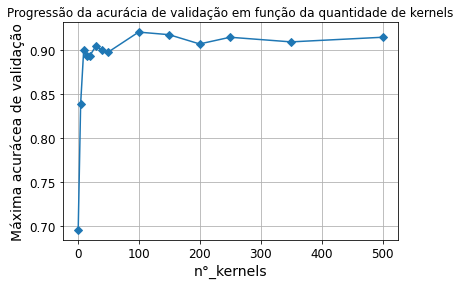

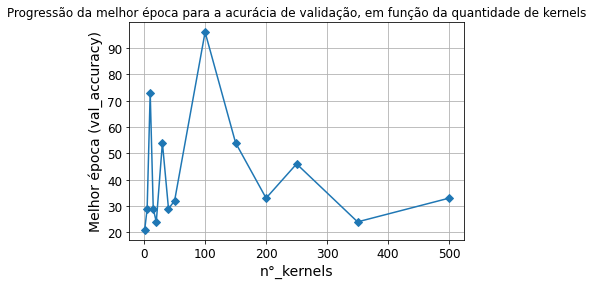

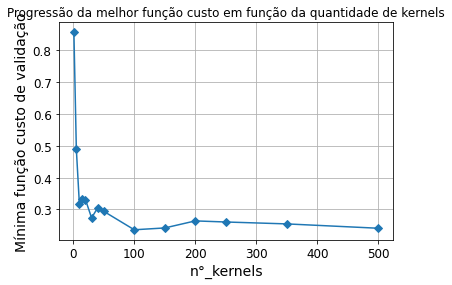

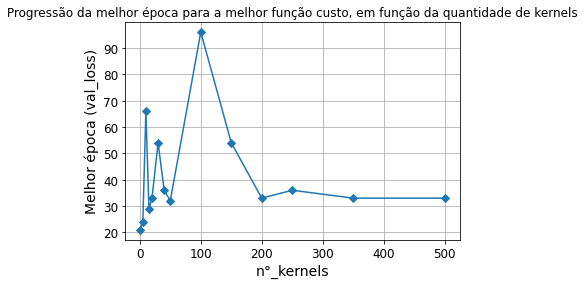

In [17]:
print("Melhores valores da acurácia de validação, em função do número de kernels:")
print(best_val_acc)
print(n_kernels)
print("Melhores valores da função custo para a validação, em função do número de kernels:")
print(best_val_loss)
# Plotando os valores das melhores acurácias de validação em função da quantidade de kernels
plt.plot(n_kernels, best_val_acc, marker='D')
plt.grid(True)
plt.title("Progressão da acurácia de validação em função da quantidade de kernels")
plt.xlabel("n°_kernels")
plt.ylabel("Máxima acurácea de validação")
plt.show()

# Plotando os valores das melhores épocas para a acurácia de validação em função da quantidade de kernels
plt.plot(n_kernels, best_epoch_acc, marker='D')
plt.grid(True)
plt.title("Progressão da melhor época para a acurácia de validação, em função da quantidade de kernels")
plt.xlabel("n°_kernels")
plt.ylabel("Melhor época (val_accuracy)")
plt.show()

# Plotando os valores dos menores valores do custo em função da quantidade de kernels
plt.plot(n_kernels, best_val_loss, marker='D')
plt.grid(True)
plt.title("Progressão da melhor função custo em função da quantidade de kernels")
plt.xlabel("n°_kernels")
plt.ylabel("Mínima função custo de validação")
plt.show()

# Plotando os valores das melhores épocas para os menores valores do custo em função da quantidade de kernels
plt.plot(n_kernels, best_epoch_loss, marker='D')
plt.grid(True)
plt.title("Progressão da melhor época para a melhor função custo, em função da quantidade de kernels")
plt.xlabel("n°_kernels")
plt.ylabel("Melhor época (val_loss)")
plt.show()

- Variando o tamanho do kernel para o caso ótimo anterior


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Para kernel de tamanho = 2


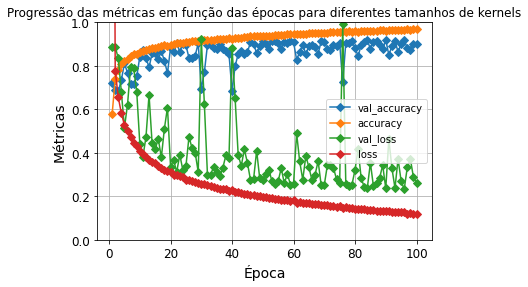

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Para kernel de tamanho = 3


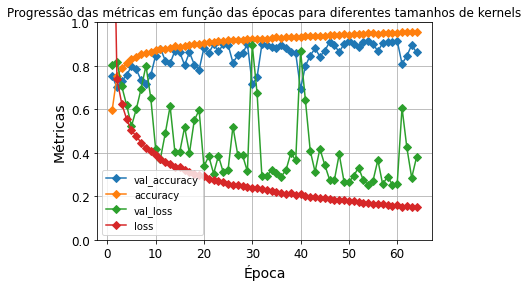

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Para kernel de tamanho = 5


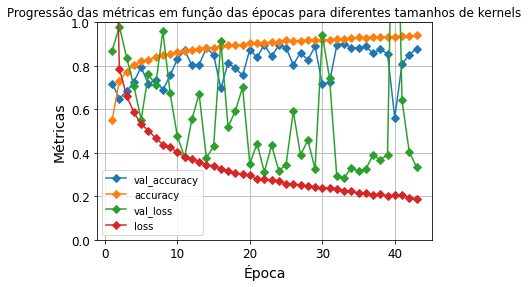

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Para kernel de tamanho = 7


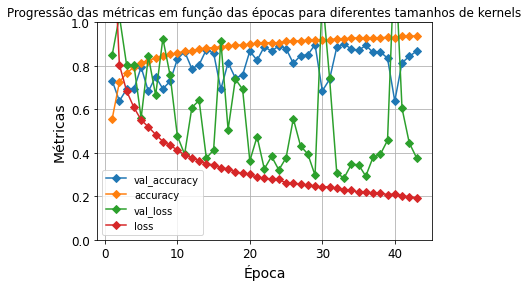

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Para kernel de tamanho = 9


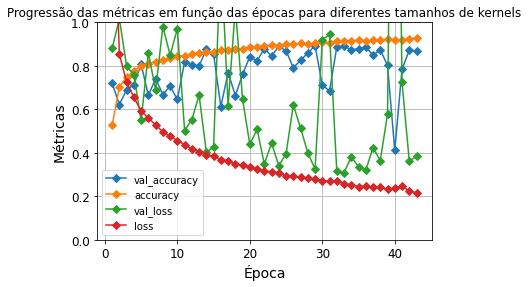

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Para kernel de tamanho = 11


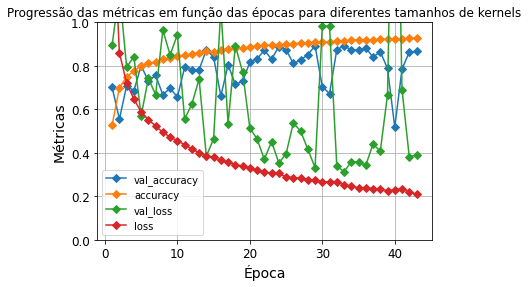

In [18]:
# O segundo treinamento foi feito fixando todos os parâmetros e variando o tamanho dos kernels
# Valores de número de kernels a serem testados:
kernel_s = [2,3,5,7,9,11]
# Vetor das melhores acurácias de validação
best_val_acc2 = []
best_val_loss2 = []
# Vetor das respectivas épocas das melhores acurácias
best_epoch_acc2 = []
best_epoch_loss2 = []
for k in np.arange(0,len(kernel_s),1):
  # Construção da CNN
  # definindo o modelo:
  sCNN_model = keras.models.Sequential()
  # Definição da camada convolucional:
  sCNN_model.add(keras.layers.Conv2D(
                  # Será testado pelo KerasTuner diferentes quantidades de kernels
                  filters= 100, # Número de Kernels fixado para o melhor caso do item anterior (maior acurácia de validação em 100 kernels)
                  kernel_size = (kernel_s[k],kernel_s[k]), # Tamanho dos kernels 
                  strides=(1,1), # Stride unitário ao logo das duas dimensões da imagem (imagem com poucos pixels)
                  input_shape=[28, 28, 3], # Formato das imagens de entrada [linhas, colunas, canais]
                  padding='same', # Default='valid',"same" faz o zero padding e quando o stride é unitário mantém as dimensões da imagem
                  data_format=None, # Default=None, canais por último no formato de entrada
                  dilation_rate=(1, 1), # Default=(1, 1), sem dilatação da convolução
                  groups=1, # Default=1, apenas um grupo para as entradas
                  activation='relu', # Função de ativação ReLu
                  use_bias=True, # Default=True. Utilizando bias no modelo
                  kernel_initializer='he_uniform', # Default='glorot_uniform'. Modo de inicialização do pesos definido como he_uniform
                  bias_initializer='zeros', # Default='zeros'. Inicia o bias como zero
                  kernel_regularizer=None, # Default=None. Não utiliza regularização
                  bias_regularizer=None, # Default=None. Não utiliza regularização do bias 
                  activity_regularizer=None, # Default=None. Sem função de regularização na saída
                  kernel_constraint=None, # Default=None. Sem Constraint function (definições para os valores dos pesos) no Kernel
                  bias_constraint=None, # Default=Non. Sem Constraint function (definições para os valores dos pesos) no vetor de bias
                  name='2D-Convolutional-Layer') # nome da camada
                ) 
  # Definição da camada de pooling (Foi escolhido o Max Pooling)
  sCNN_model.add(keras.layers.MaxPool2D(pool_size=(2,2), # Default=(2,2). Tamanho da janela de pooling definida como 2x2
                      strides=(1,1), # Definição do stride das janelas de pooling como unitário
                      padding='valid', # Default='valid'. Sem padding
                      data_format=None, # Default=None. Canais por último no formato de entrada
                      name='2D-MaxPool-Layer') # nome da camada
                ) 
  # Definição da camada flatten antes da camada densa
  sCNN_model.add(keras.layers.Flatten(name='Flatten-Layer'))
  # Definição da camada densa de saída do tipo softmax
  sCNN_model.add(keras.layers.Dense(8, activation='softmax', name='Output-Layer'))

  # Compilação do modelo
  sCNN_model.compile(optimizer='sgd', # Otimizador sgd escolhido para o treinamento
                    loss='SparseCategoricalCrossentropy', # Função custo. Escolhida a entropia cruzada
                    metrics=['accuracy'], # A acurácia foi utilizada como métrica
                    )

  # fit do modelo
  sCNN_history = sCNN_model.fit(x_train, # dados de entrada
                    y_train, # labels do treinamento
                    batch_size=50, # Tamanho do batch para o treinamento (quantas amostras usa por vez)
                    epochs=100, # Número de épocas (quantas vezes percorre todos os dados)
                    verbose=0, # Grau de informações printadas
                    callbacks= keras.callbacks.EarlyStopping(monitor='val_loss', patience=10), # Adição de Early Stopping para evitar overfitting
                    validation_data=(x_valid, y_valid) # Dados de validação  
                    )
  print(sCNN_history.history.keys())
  # Salvando os valores das melhores acurácias de validação e as melhores épocas para este parâmetro
  best_val_acc2.append(np.max(sCNN_history.history['val_accuracy']))
  best_epoch_acc2.append(sCNN_history.history['val_accuracy'].index(np.max(sCNN_history.history['val_accuracy']))+1)
  # Salvando os melhores valores da função custo e as melhores épocas para este parâmetro
  best_val_loss2.append(np.min(sCNN_history.history['val_loss']))
  best_epoch_loss2.append(sCNN_history.history['val_loss'].index(np.min(sCNN_history.history['val_loss']))+1)
  # Indica o tamnho do kernel utilizado
  print("Para kernel de tamanho =", kernel_s[k])  
  # Plotando os gráficos das métricas em função das épocas
  plt.plot(np.arange(1,len(sCNN_history.history['val_accuracy'])+1,1),sCNN_history.history['val_accuracy'], marker='D', label='val_accuracy')
  plt.plot(np.arange(1,len(sCNN_history.history['accuracy'])+1,1),sCNN_history.history['accuracy'], marker='D', label='accuracy')
  plt.plot(np.arange(1,len(sCNN_history.history['val_loss'])+1,1),sCNN_history.history['val_loss'], marker='D', label='val_loss')
  plt.plot(np.arange(1,len(sCNN_history.history['loss'])+1,1),sCNN_history.history['loss'], marker='D', label='loss')
  plt.gca().set_ylim(0, 1)
  plt.legend()
  plt.grid(True)
  plt.title("Progressão das métricas em função das épocas para diferentes tamanhos de kernels")
  plt.xlabel("Época")
  plt.ylabel("Métricas")
  plt.show()


Melhores valores da acurácia de validação, em função do tamanho do kernel:
[0.9193925261497498, 0.9153037667274475, 0.9001168012619019, 0.9007009267807007, 0.8925233483314514, 0.8919392228126526]
Melhores valores da função custo para a validação, em função do tamanho do kernel:
[0.2323637753725052, 0.25321483612060547, 0.2840963304042816, 0.28419792652130127, 0.3077225387096405, 0.31247055530548096]


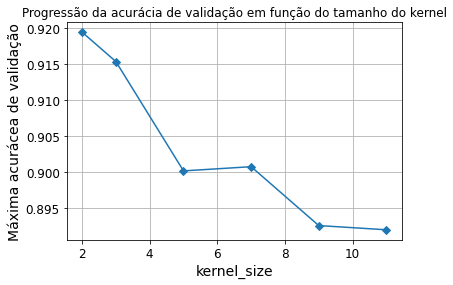

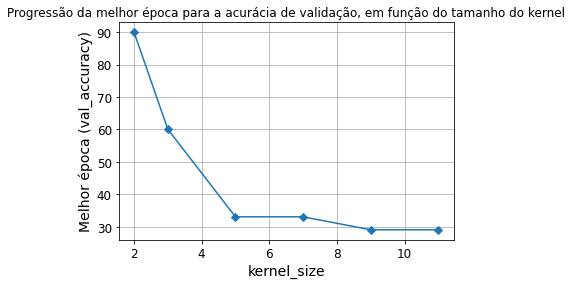

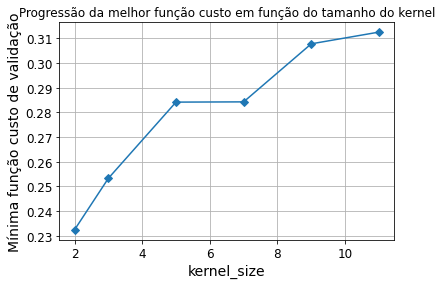

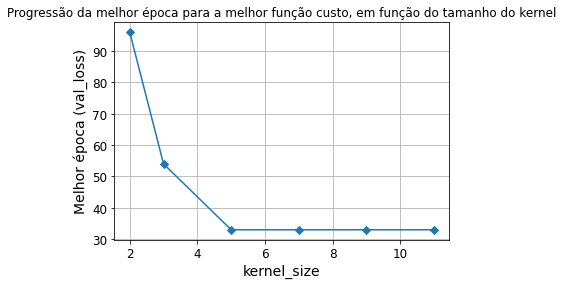

In [19]:
print("Melhores valores da acurácia de validação, em função do tamanho do kernel:")
print(best_val_acc2)
print("Melhores valores da função custo para a validação, em função do tamanho do kernel:")
print(best_val_loss2)
# Plotando os valores das melhores acurácias de validação em função do tamanho do kernel
plt.plot(kernel_s, best_val_acc2, marker='D')
plt.grid(True)
plt.title("Progressão da acurácia de validação em função do tamanho do kernel")
plt.xlabel("kernel_size")
plt.ylabel("Máxima acurácea de validação")
plt.show()

# Plotando os valores das melhores épocas para a acurácia de validação em função da quantidade de kernels
plt.plot(kernel_s, best_epoch_acc2, marker='D')
plt.grid(True)
plt.title("Progressão da melhor época para a acurácia de validação, em função do tamanho do kernel")
plt.xlabel("kernel_size")
plt.ylabel("Melhor época (val_accuracy)")
plt.show()

# Plotando os valores dos menores valores do custo em função da quantidade de kernels
plt.plot(kernel_s, best_val_loss2, marker='D')
plt.grid(True)
plt.title("Progressão da melhor função custo em função do tamanho do kernel")
plt.xlabel("kernel_size")
plt.ylabel("Mínima função custo de validação")
plt.show()

# Plotando os valores das melhores épocas para os menores valores do custo em função da quantidade de kernels
plt.plot(kernel_s, best_epoch_loss2, marker='D')
plt.grid(True)
plt.title("Progressão da melhor época para a melhor função custo, em função do tamanho do kernel")
plt.xlabel("kernel_size")
plt.ylabel("Melhor época (val_loss)")
plt.show()

## Teste do melhor modelo da CNN simples

- Retreinamento com os hiperparâmetros ótimos

Epoch 1/100
274/274 - 2s - loss: 3.1843 - accuracy: 0.6320 - 2s/epoch - 7ms/step
Epoch 2/100
274/274 - 1s - loss: 0.6974 - accuracy: 0.7631 - 1s/epoch - 5ms/step
Epoch 3/100
274/274 - 1s - loss: 0.5858 - accuracy: 0.8029 - 1s/epoch - 5ms/step
Epoch 4/100
274/274 - 1s - loss: 0.5284 - accuracy: 0.8256 - 1s/epoch - 5ms/step
Epoch 5/100
274/274 - 1s - loss: 0.4838 - accuracy: 0.8391 - 1s/epoch - 5ms/step
Epoch 6/100
274/274 - 1s - loss: 0.4557 - accuracy: 0.8473 - 1s/epoch - 5ms/step
Epoch 7/100
274/274 - 1s - loss: 0.4300 - accuracy: 0.8563 - 1s/epoch - 5ms/step
Epoch 8/100
274/274 - 1s - loss: 0.4114 - accuracy: 0.8623 - 1s/epoch - 5ms/step
Epoch 9/100
274/274 - 1s - loss: 0.3922 - accuracy: 0.8715 - 1s/epoch - 5ms/step
Epoch 10/100
274/274 - 1s - loss: 0.3821 - accuracy: 0.8711 - 1s/epoch - 5ms/step
Epoch 11/100
274/274 - 1s - loss: 0.3641 - accuracy: 0.8792 - 1s/epoch - 5ms/step
Epoch 12/100
274/274 - 1s - loss: 0.3525 - accuracy: 0.8852 - 1s/epoch - 5ms/step
Epoch 13/100
274/274 - 2s

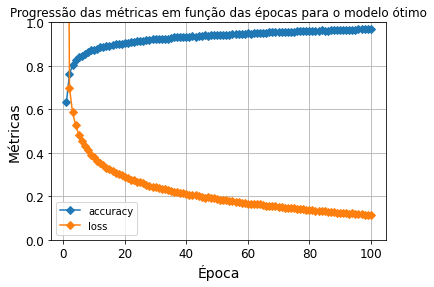

In [20]:
# Retreinando a rede para os parâmetros ótimos
# Construção da CNN
# definindo o modelo:
sCNN_model = keras.models.Sequential()
# Definição da camada convolucional:
sCNN_model.add(keras.layers.Conv2D(
                # Será testado pelo KerasTuner diferentes quantidades de kernels
                filters= 100, # Número de Kernels fixado para o melhor caso do item anterior (maior acurácia de validação em 100 kernels)
                kernel_size = (2,2), # Tamanho dos kernels fixado para o valor ótimo obtido anteriormente (2x2)
                strides=(1,1), # Stride unitário ao logo das duas dimensões da imagem (imagem com poucos pixels)
                input_shape=[28, 28, 3], # Formato das imagens de entrada [linhas, colunas, canais]
                padding='same', # Default='valid',"same" faz o zero padding e quando o stride é unitário mantém as dimensões da imagem
                data_format=None, # Default=None, canais por último no formato de entrada
                dilation_rate=(1, 1), # Default=(1, 1), sem dilatação da convolução
                groups=1, # Default=1, apenas um grupo para as entradas
                activation='relu', # Função de ativação ReLu
                use_bias=True, # Default=True. Utilizando bias no modelo
                kernel_initializer='he_uniform', # Default='glorot_uniform'. Modo de inicialização do pesos definido como he_uniform
                bias_initializer='zeros', # Default='zeros'. Inicia o bias como zero
                kernel_regularizer=None, # Default=None. Não utiliza regularização
                bias_regularizer=None, # Default=None. Não utiliza regularização do bias 
                activity_regularizer=None, # Default=None. Sem função de regularização na saída
                kernel_constraint=None, # Default=None. Sem Constraint function (definições para os valores dos pesos) no Kernel
                bias_constraint=None, # Default=Non. Sem Constraint function (definições para os valores dos pesos) no vetor de bias
                name='2D-Convolutional-Layer') # nome da camada
              ) 
# Definição da camada de pooling (Foi escolhido o Max Pooling)
sCNN_model.add(keras.layers.MaxPool2D(pool_size=(2,2), # Default=(2,2). Tamanho da janela de pooling definida como 2x2
                    strides=(1,1), # Definição do stride das janelas de pooling como unitário
                    padding='valid', # Default='valid'. Sem padding
                    data_format=None, # Default=None. Canais por último no formato de entrada
                    name='2D-MaxPool-Layer') # nome da camada
              ) 
# Definição da camada flatten antes da camada densa
sCNN_model.add(keras.layers.Flatten(name='Flatten-Layer'))
# Definição da camada densa de saída do tipo softmax
sCNN_model.add(keras.layers.Dense(8, activation='softmax', name='Output-Layer'))

# Compilação do modelo
sCNN_model.compile(optimizer='sgd', # Otimizador sgd escolhido para o treinamento
                  loss='SparseCategoricalCrossentropy', # Função custo. Escolhida a entropia cruzada
                  metrics=['accuracy'], # A acurácia foi utilizada como métrica
                  )

# fit do modelo
sCNN_history = sCNN_model.fit(x_tv, # dados de entrada de treinamento + validação
                  y_tv, # labels do treinamento + validação
                  batch_size=50, # Tamanho do batch para o treinamento (quantas amostras usa por vez)
                  epochs=100, # Número de épocas (quantas vezes percorre todos os dados)
                  verbose=2, # Grau de informações printadas
                  callbacks= None,
                  validation_data = None  
                  )
print(sCNN_history.history.keys())
# Plotando os gráficos das métricas em função das épocas
plt.plot(np.arange(1,len(sCNN_history.history['accuracy'])+1,1),sCNN_history.history['accuracy'], marker='D', label='accuracy')
plt.plot(np.arange(1,len(sCNN_history.history['loss'])+1,1),sCNN_history.history['loss'], marker='D', label='loss')
plt.gca().set_ylim(0, 1)
plt.legend()
plt.grid(True)
plt.title("Progressão das métricas em função das épocas para o modelo ótimo")
plt.xlabel("Época")
plt.ylabel("Métricas")
plt.show()

- Acurácia Global e demais métricas

In [22]:
# Resumo do modelo
print("Model summary")
sCNN_model.summary() # print model summary
print("")

# Model Evaluation
print("Model Evaluation")
sCNN_test = sCNN_model.evaluate(x_test, y_test)
print("A acurácia global para os dados de teste obtida foi de 0.9100")



Model summary
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 2D-Convolutional-Layer (Con  (None, 28, 28, 100)      1300      
 v2D)                                                            
                                                                 
 2D-MaxPool-Layer (MaxPoolin  (None, 27, 27, 100)      0         
 g2D)                                                            
                                                                 
 Flatten-Layer (Flatten)     (None, 72900)             0         
                                                                 
 Output-Layer (Dense)        (None, 8)                 583208    
                                                                 
Total params: 584,508
Trainable params: 584,508
Non-trainable params: 0
_________________________________________________________________

Model Evaluation
107/107 [======

In [23]:
# Valores previstos:
y_pred_sCNN = np.array(tf.math.argmax(sCNN_model.predict(x_test),axis=1))
# Resultados da previsão:
print(metrics.classification_report(y_test, y_pred_sCNN))

107/107 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       244
           1       0.97      0.96      0.97       624
           2       0.91      0.95      0.93       311
           3       0.86      0.73      0.79       579
           4       0.91      0.91      0.91       243
           5       0.76      0.85      0.80       284
           6       0.93      0.97      0.95       666
           7       1.00      1.00      1.00       470

    accuracy                           0.91      3421
   macro avg       0.90      0.91      0.90      3421
weighted avg       0.91      0.91      0.91      3421



- Matriz de Confusão para os dados de teste

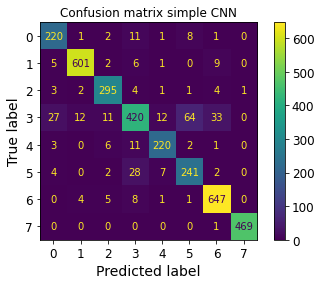

In [24]:
# Matriz de confusão
sCNN_cm=metrics.confusion_matrix(y_test, y_pred_sCNN )
cm_fig=metrics.ConfusionMatrixDisplay(confusion_matrix=sCNN_cm)
cm_fig.plot()
plt.title('Confusion matrix simple CNN')
plt.show()

- Cinco padrões de teste que foram classificados incorretamente, indicando a classe esperada e as probabilidades estimadas pela rede

Para a amostra 0  do conjunto de teste:
Classe esperada: 3
Classe estimada: 5
Imagem:


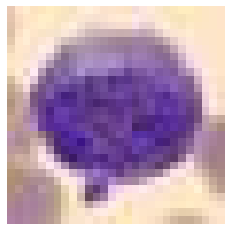


Probabilidades:
1/1 [==============================] - 0s 65ms/step
Classe 0: 0.056578383
Classe 1: 0.00012366218
Classe 2: 2.0541852
Classe 3: 4.2980995
Classe 4: 0.55361676
Classe 5: 93.035675
Classe 6: 0.0017309714
Classe 7: 8.144543e-08

---------------------------------------------------------------------------------------------

Para a amostra 4  do conjunto de teste:
Classe esperada: 1
Classe estimada: 3
Imagem:


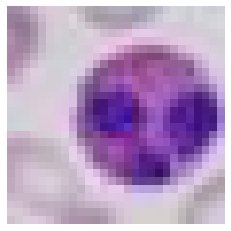


Probabilidades:
1/1 [==============================] - 0s 21ms/step
Classe 0: 0.61742336
Classe 1: 44.066574
Classe 2: 0.0033612545
Classe 3: 54.807407
Classe 4: 0.0036676163
Classe 5: 0.1399648
Classe 6: 0.36160398
Classe 7: 6.722571e-08

---------------------------------------------------------------------------------------------

Para a amostra 23  do conjunto de teste:
Classe esperada: 5
Classe estimada: 4
Imagem:


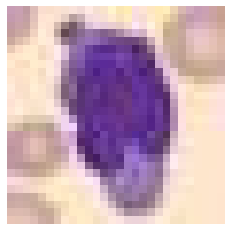


Probabilidades:
1/1 [==============================] - 0s 21ms/step
Classe 0: 1.2664273
Classe 1: 0.0059530563
Classe 2: 0.08817363
Classe 3: 0.9564382
Classe 4: 57.37937
Classe 5: 40.297745
Classe 6: 0.0058234064
Classe 7: 6.576726e-05

---------------------------------------------------------------------------------------------

Para a amostra 25  do conjunto de teste:
Classe esperada: 6
Classe estimada: 2
Imagem:


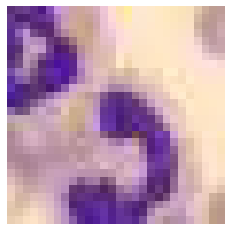


Probabilidades:
1/1 [==============================] - 0s 20ms/step
Classe 0: 0.13434583
Classe 1: 3.5553198
Classe 2: 91.50221
Classe 3: 3.8633657
Classe 4: 0.37077183
Classe 5: 0.0034655412
Classe 6: 0.2853677
Classe 7: 0.2851522

---------------------------------------------------------------------------------------------

Para a amostra 28  do conjunto de teste:
Classe esperada: 3
Classe estimada: 5
Imagem:


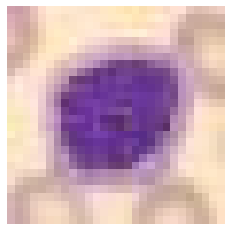


Probabilidades:
1/1 [==============================] - 0s 21ms/step
Classe 0: 0.16877878
Classe 1: 0.030983318
Classe 2: 0.012358898
Classe 3: 27.783007
Classe 4: 1.2734534
Classe 5: 69.98733
Classe 6: 0.7437192
Classe 7: 0.0003709885

---------------------------------------------------------------------------------------------



In [25]:
classes = [0,1,2,3,4,5,6,7]
error = []
# Identifica os índices das 5 primeiras labels previstas de forma errada
for j in range(0,len(y_pred_sCNN),1):
  if y_pred_sCNN[j] != y_test[j]:
    error.append(j)
    error = error[:5]
# Mostra a classe obtida, a classe esperada e as probabilidades para os 5 primeiros erros
for index in range(0,len(error),1):
  print("Para a amostra", error[index]," do conjunto de teste:")
  print("Classe esperada:",y_test[error[index]])
  print("Classe estimada:",y_pred_sCNN[error[index]])
  print("Imagem:")
  plt.imshow(test_img[error[index]],cmap="gray")
  plt.axis("off")
  plt.show()
  print("")
  print("Probabilidades:")
  x_teste= tf.expand_dims(x_test[error[index]], 0)  # Create batch axis
  prob = sCNN_model.predict(x_teste)*100
  print("Classe 0:", prob[0][0])
  print("Classe 1:", prob[0][1])
  print("Classe 2:", prob[0][2])
  print("Classe 3:", prob[0][3])
  print("Classe 4:", prob[0][4])
  print("Classe 5:", prob[0][5])
  print("Classe 6:", prob[0][6])
  print("Classe 7:", prob[0][7])
  print("")
  print("---------------------------------------------------------------------------------------------")
  print("")


## Treinamento e validação da CNN complexa (inspirada na ResNet)

## Teste do melhor modelo da CNN complexa (inspirada na ResNet)


- Acurácia Global e demais métricas

- Matriz de Confusão para os dados de teste

- Cinco padrões de teste que foram classificados incorretamente, indicando a classe esperada e as probabilidades estimadas pela rede